In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [6]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow_backend.db")
mlflow.set_experiment("nyc-yellow-taxi-prediction")

2023/05/26 14:59:25 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/05/26 14:59:25 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='/Users/oshan/GoogleDrives/EEDrive/OshanProjects/20230513_zoomcamp_mlops/lesson2-experiment_tracking/mlruns/1', creation_time=1685093365875, experiment_id='1', last_update_time=1685093365875, lifecycle_stage='active', name='nyc-yellow-taxi-prediction', tags={}>

In [7]:
class filepaths:
    train_data = './data/yellow_tripdata_2022-01.parquet'
    val_data = './data/yellow_tripdata_2022-02.parquet'


df = pd.read_parquet(filepaths.train_data)


def fix_col_names(df):
    df = df.rename(
        columns={
            'tpep_dropoff_datetime': 'lpep_dropoff_datetime',
            'tpep_pickup_datetime': 'lpep_pickup_datetime'
        })
    return df


df = fix_col_names(df)

In [8]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [9]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

7.001496179375642

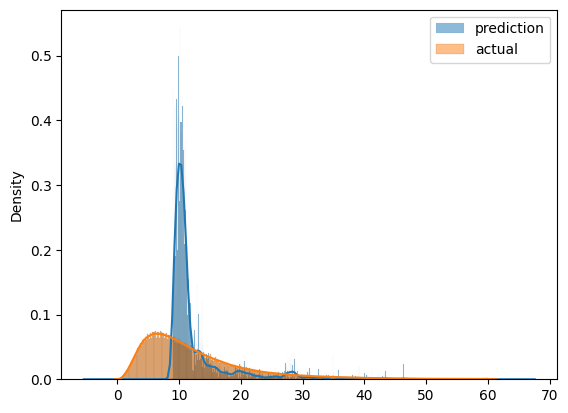

In [13]:
sns.histplot(y_pred,
             label='prediction',
             kde=True,
             stat='density',
             kde_kws=dict(cut=3))
sns.histplot(y_train,
             label='actual',
             kde=True,
             kde_kws=dict(cut=3),
             stat='density')

plt.legend()

In [14]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df = fix_col_names(df)
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df

In [15]:
df_train = read_dataframe(filepaths.train_data)
df_val = read_dataframe(filepaths.val_data)

In [16]:
len(df_train), len(df_val)

(2421440, 2918187)

In [17]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [18]:
categorical = ['PU_DO']  #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [19]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [23]:
with mlflow.start_run():
    mlflow.set_tag("author", "oshan")
    mlflow.log_param('train_path', filepaths.train_data)

    alpha = 0.1
    mlflow.log_param('alpha', alpha)
    lr = Lasso(alpha=alpha)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric('rmse', rmse)
    with open('models/lasso_reg.bin', 'wb') as f_out:
        pickle.dump((dv, lr), f_out)
    mlflow.log_artifact("models/lasso_reg.bin", 'model_pickle')

In [24]:
mlflow.sklearn.autolog()

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
rmse = mean_squared_error(y_pred, y_val, squared=False)
mlflow.log_metric('rmse_val', rmse)

2023/05/26 15:54:28 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'bb95bc2c4d804e25879d2c3bb07ae177', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/05/26 15:54:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/oshan/opt/miniconda3/envs/course_mlops/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


In [26]:
mlflow.end_run()

### XGboost and mlflow

In [38]:
import xgboost as xgb

from hyperopt import fmin, STATUS_OK, hp, tpe, Trials

from hyperopt.pyll import scope

In [39]:
train = xgb.DMatrix(X_train, y_train)
valid = xgb.DMatrix(X_val, y_val)

In [40]:
def objective(params):

    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(params=params,
                            dtrain=train,
                            num_boost_round=50,
                            evals=[(valid, "validation")],
                            early_stopping_rounds=5)

        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_pred, y_val, squared=False)
        mlflow.log_metric("rmse", rmse)
    return {'loss': rmse, 'status': STATUS_OK}

In [41]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 30, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    
    'objective': 'reg:squarederror',
    'seed': 42
}

In [42]:
best_result = fmin(fn=objective,
                   space=search_space,
                   algo=tpe.suggest,
                   max_evals=10,
                   trials=Trials())

[0]	validation-rmse:15.73929                                                
[1]	validation-rmse:15.09309                                                
[2]	validation-rmse:14.48240                                                
[3]	validation-rmse:13.90578                                                
[4]	validation-rmse:13.36119                                                
[5]	validation-rmse:12.84733                                                
[6]	validation-rmse:12.36274                                                
[7]	validation-rmse:11.90565                                                
[8]	validation-rmse:11.47513                                                
[9]	validation-rmse:11.06953                                                
[10]	validation-rmse:10.68782                                               
[11]	validation-rmse:10.32869                                               
[12]	validation-rmse:9.99094                                                

[6]	validation-rmse:5.30966                                                 
[7]	validation-rmse:5.27323                                                 
[8]	validation-rmse:5.25754                                                 
[9]	validation-rmse:5.24439                                                 
[10]	validation-rmse:5.23817                                                
[11]	validation-rmse:5.23377                                                
[12]	validation-rmse:5.23068                                                
[13]	validation-rmse:5.22411                                                
[14]	validation-rmse:5.22165                                                
[15]	validation-rmse:5.22018                                                
[16]	validation-rmse:5.21796                                                
[17]	validation-rmse:5.21638                                                
[18]	validation-rmse:5.21464                                                

[12]	validation-rmse:6.75767                                                
[13]	validation-rmse:6.52898                                                
[14]	validation-rmse:6.33426                                                
[15]	validation-rmse:6.16843                                                
[16]	validation-rmse:6.02710                                                
[17]	validation-rmse:5.90701                                                
[18]	validation-rmse:5.80476                                                
[19]	validation-rmse:5.71758                                                
[20]	validation-rmse:5.64317                                                
[21]	validation-rmse:5.57929                                                
[22]	validation-rmse:5.52428                                                
[23]	validation-rmse:5.47680                                                
[24]	validation-rmse:5.43590                                                

[18]	validation-rmse:5.14104                                                
[19]	validation-rmse:5.13466                                                
[20]	validation-rmse:5.13026                                                
[21]	validation-rmse:5.12672                                                
[22]	validation-rmse:5.12362                                                
[23]	validation-rmse:5.12141                                                
[24]	validation-rmse:5.11762                                                
[25]	validation-rmse:5.11575                                                
[26]	validation-rmse:5.11395                                                
[27]	validation-rmse:5.11126                                                
[28]	validation-rmse:5.10986                                                
[29]	validation-rmse:5.10852                                                
[30]	validation-rmse:5.10716                                                

[24]	validation-rmse:5.07921                                                
[25]	validation-rmse:5.07716                                                
[26]	validation-rmse:5.07544                                                
[27]	validation-rmse:5.07062                                                
[28]	validation-rmse:5.06930                                                
[29]	validation-rmse:5.06775                                                
[30]	validation-rmse:5.06581                                                
[31]	validation-rmse:5.06423                                                
[32]	validation-rmse:5.06261                                                
[33]	validation-rmse:5.06057                                                
[34]	validation-rmse:5.05876                                                
[35]	validation-rmse:5.05721                                                
[36]	validation-rmse:5.05582                                                

In [43]:
best_result

{'learning_rate': 0.7641768942747523,
 'max_depth': 28.0,
 'min_child_weight': 3.0944429342261293,
 'req_alpha': 0.014551278531257265,
 'req_lambda': 0.006226148382478437}

In [48]:
best_result = {
    'learning_rate': 0.7641768942747523,
    'max_depth': 28,
    'min_child_weight': 3.0944429342261293,
    'reg_alpha': 0.014551278531257265,
    'reg_lambda': 0.006226148382478437
}

In [49]:
mlflow.xgboost.autolog()
params = best_result
with mlflow.start_run():
    mlflow.set_tag("model", "xgboost")
    mlflow.log_params(params)
    booster = xgb.train(params=params,
                        dtrain=train,
                        num_boost_round=50,
                        evals=[(valid, "validation")],
                        early_stopping_rounds=5)

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_pred, y_val, squared=False)
    mlflow.log_metric("rmse", rmse)
    mlflow.xgboost.log_model(booster, 'model_mlflow')

[0]	validation-rmse:6.87251
[1]	validation-rmse:5.40966
[2]	validation-rmse:5.17960
[3]	validation-rmse:5.12894
[4]	validation-rmse:5.11513
[5]	validation-rmse:5.10444
[6]	validation-rmse:5.09902
[7]	validation-rmse:5.09343
[8]	validation-rmse:5.08943
[9]	validation-rmse:5.08536
[10]	validation-rmse:5.08095
[11]	validation-rmse:5.07227
[12]	validation-rmse:5.06848
[13]	validation-rmse:5.06503
[14]	validation-rmse:5.06181
[15]	validation-rmse:5.05887
[16]	validation-rmse:5.05537
[17]	validation-rmse:5.05256
[18]	validation-rmse:5.04702
[19]	validation-rmse:5.04474
[20]	validation-rmse:5.04166
[21]	validation-rmse:5.03915
[22]	validation-rmse:5.03570
[23]	validation-rmse:5.03267
[24]	validation-rmse:5.02993
[25]	validation-rmse:5.02741
[26]	validation-rmse:5.02541
[27]	validation-rmse:5.02353
[28]	validation-rmse:5.02138
[29]	validation-rmse:5.01953
[30]	validation-rmse:5.01810
[31]	validation-rmse:5.01614
[32]	validation-rmse:5.01388
[33]	validation-rmse:5.01189
[34]	validation-rmse:5.0

2023/05/26 17:10:58 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
